# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

In [2]:
data = pd.read_csv('data/flightsrandom200000.csv')

In [3]:
p = pd.read_csv('data/passengers.csv')

In [4]:
df2 = p[['departures_performed','seats','passengers','carrier','month']].groupby(['carrier','month']).mean().reset_index()

In [5]:
df = data[['fl_date','mkt_carrier','origin','dest','crs_dep_time','crs_arr_time','crs_elapsed_time','distance','arr_delay','dep_delay']]

In [6]:
df.head()

,fl_date,mkt_carrier,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay,dep_delay
0,3/27/2019,DL,RSW,ATL,630,816,106,515,-7.0,-5.0
1,3/8/2018,AA,GSO,CLT,1745,1847,62,83,-8.0,-8.0
2,11/14/2018,UA,ORD,DEN,750,928,158,888,135.0,160.0
3,8/2/2018,DL,SLC,TUS,855,944,109,601,-1.0,-1.0
4,10/14/2018,DL,XNA,ATL,600,843,103,589,-13.0,-1.0


### Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

DATETIME ENCODING

In [7]:
df.loc[:,'month'] = df['fl_date'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y').month)
df.loc[:,'weekday'] = df['fl_date'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y').weekday())

df.loc[:,'crs_dep_time']=df['crs_dep_time'].replace(2400.0,0)
df.loc[:,'crs_arr_time']=df['crs_arr_time'].replace(2400.0,0)
df.loc[:,'dep_hour'] = df['crs_dep_time'].apply(lambda x: datetime.datetime.strptime(str(int(x)).zfill(4), '%H%M').hour)
df.loc[:,'arr_hour'] = df['crs_arr_time'].apply(lambda x: datetime.datetime.strptime(str(int(x)).zfill(4), '%H%M').hour)

D:\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
D:\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [8]:
df = df.drop(columns=['fl_date','crs_dep_time','crs_arr_time'])

In [9]:
df = pd.merge(df,df2, how = 'left', left_on=['mkt_carrier','month'], right_on=['carrier','month']).drop(columns='carrier')

In [10]:
df['pas/dep'] = df['passengers']/df['departures_performed']
df['filled'] = df['passengers']/df['seats']
df=df.drop(columns=['departures_performed','seats','passengers'])

AIRPORT ENCODING

In [11]:
air = (df.groupby('origin').count().div(len(df))*100).sort_values('dest',ascending=False).reset_index()
sum = 0
ori = 0
for i, row in air.iterrows():
    sum += row[1]
    if(sum>=96):
        ori = i
        break
air = (df.groupby('dest').count().div(len(df))*100).sort_values('origin',ascending=False).reset_index()
sum = 0
des = 0
for i, row in air.iterrows():
    sum += row[1]
    if(sum>=96):
        des = i
        break


lst = df.groupby('origin').count().sort_values('dest',ascending=False).reset_index().loc[ori:,'origin']
df.loc[df['origin'].isin(lst),'origin'] = 'Other'
lst = df.groupby('dest').count().sort_values('origin',ascending=False).reset_index().loc[des:,'dest']
df.loc[df['dest'].isin(lst),'dest'] = 'Other'

In [12]:
temp = df.groupby('origin').count().sort_values('dest',ascending=False).reset_index().iloc[:,:1]
temp['origin_index'] = temp.index
df = pd.merge(df,temp,how='left',left_on='origin',right_on='origin')

temp = df.groupby('dest').count().sort_values('origin',ascending=False).reset_index().iloc[:,:1]
temp['dest_index'] = temp.index
df = pd.merge(df,temp,how='left',left_on='dest',right_on='dest')
df = df.drop(columns=['origin','dest'])

temp = df.groupby('mkt_carrier').count().sort_values('origin_index',ascending=False).reset_index().iloc[:,:1]
temp['carrier_index'] = temp.index
df = pd.merge(df,temp,how='left',left_on='mkt_carrier',right_on='mkt_carrier')

### Feature Selection / Dimensionality Reduction

We need to apply different selection techniques to find out which one will be the best for our problems.

- Original Features vs. PCA conponents?

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['crs_elapsed_time','distance','pas/dep']] = scaler.fit_transform(df[['crs_elapsed_time','distance','pas/dep']])

In [42]:
df = df.dropna()
y = df['arr_delay']
df = df.drop(columns='arr_delay')

KeyError: 'arr_delay'

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df,y,test_size = .2,random_state=0)

In [44]:
X_train['avg_dep_delay'] = df.groupby(['mkt_carrier','month'])['dep_delay'].transform('mean')
X_test['avg_dep_delay'] = df.groupby(['mkt_carrier','month'])['dep_delay'].transform('mean')
X_train = X_train.drop(columns=['mkt_carrier','dep_delay'])
X_test = X_test.drop(columns=['mkt_carrier','dep_delay'])

<ipython-input-44-3509b5a4cf37>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['avg_dep_delay'] = df.groupby(['mkt_carrier','month'])['dep_delay'].transform('mean')
<ipython-input-44-3509b5a4cf37>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['avg_dep_delay'] = df.groupby(['mkt_carrier','month'])['dep_delay'].transform('mean')


PCA

In [38]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components = 5)
# X_train = pd.DataFrame(pca.fit_transform(X_train))
# X_test = pd.DataFrame(pca.fit_transform(X_test))

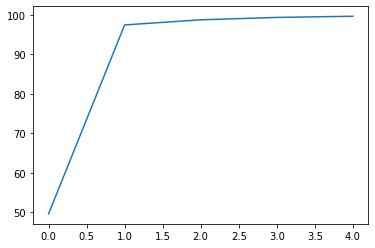

In [39]:
# plt.plot(np.cumsum(np.round(pca.explained_variance_ratio_,decimals = 3)*100))
# plt.show()

### Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

In [45]:
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics

In [46]:
from sklearn.linear_model import LinearRegression

In [47]:
reg = LinearRegression()

In [48]:
reg.fit(X_train,y_train)

LinearRegression()

In [49]:
y_pred = reg.predict(X_test)

In [50]:
metrics.mean_squared_error(y_test,y_pred)

2624.1877511085386

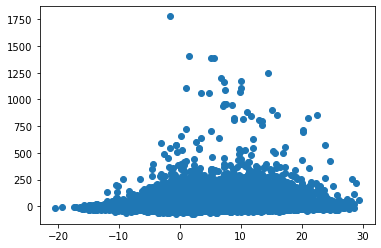

In [51]:
plt.scatter(y_pred,y_test)
plt.show()

In [52]:
metrics.r2_score(y_test,y_pred)

0.013880163144307178

In [108]:
from sklearn.linear_model import Ridge

In [109]:
param_grid = {
    'alpha': [0.001,0.01,0.1,0.5]
}

grid = GridSearchCV(estimator = Ridge(normalize = True), param_grid = param_grid, n_jobs=-1, verbose = 1)

In [110]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    2.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.2s finished


GridSearchCV(estimator=Ridge(normalize=True), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.5]}, verbose=1)

In [111]:
grid.best_params_

{'alpha': 0.001}

In [112]:
reg = Ridge(alpha = grid.best_params_['alpha'], normalize = True)

In [113]:
reg.fit(X_train,y_train)

Ridge(alpha=0.001, normalize=True)

In [114]:
y_pred = reg.predict(X_test)

In [115]:
metrics.mean_squared_error(y_test,y_pred)

2618.959818280622

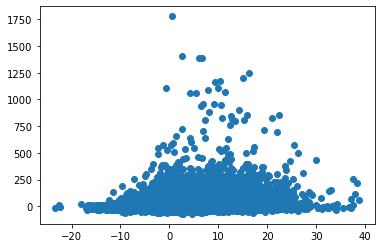

In [116]:
plt.scatter(y_pred,y_test)
plt.show()

In [117]:
metrics.r2_score(y_test,y_pred)

0.015844720849897964

In [118]:
from sklearn.ensemble import RandomForestRegressor

In [119]:
param_grid = {
    'n_estimators': [75,100,150],
    'max_depth': [4,5,6],
}

grid = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_grid, n_jobs=-1, verbose = 1)

In [120]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.8min finished


GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6],
                         'n_estimators': [75, 100, 150]},
             verbose=1)

In [121]:
grid.best_params_

{'max_depth': 6, 'n_estimators': 150}

In [122]:
reg = RandomForestRegressor(max_depth=grid.best_params_['max_depth'],n_estimators=grid.best_params_['n_estimators'])

In [123]:
reg.fit(X_train,y_train)

RandomForestRegressor(max_depth=6, n_estimators=150)

In [124]:
y_pred = reg.predict(X_test)

In [125]:
metrics.mean_squared_error(y_test,y_pred)

2615.777563314524

In [126]:
metrics.r2_score(y_test,y_pred)

0.01704055173001562

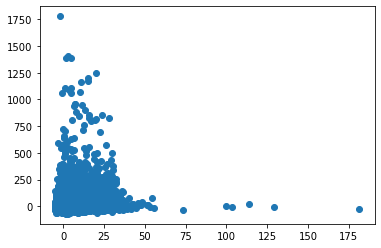

In [127]:
plt.scatter(y_pred,y_test)
plt.show()

### Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**

In [84]:
data2 = pd.read_csv('data/flights_test.csv')
X2 = data2[['fl_date','mkt_carrier','origin','dest','crs_dep_time','crs_arr_time','crs_elapsed_time','distance']]

In [85]:
X2.loc[:,'month'] = X2['fl_date'].apply(lambda x: datetime.datetime.fromtimestamp(int(str(x)[:10])).month)
X2.loc[:,'day'] = X2['fl_date'].apply(lambda x: datetime.datetime.fromtimestamp(int(str(x)[:10])).day)
X2=X2[X2['day']<=7]
X2=X2.drop(columns='day')
X2.loc[:,'weekday'] = X2['fl_date'].apply(lambda x: datetime.datetime.fromtimestamp(int(str(x)[:10])).weekday())

D:\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
D:\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [86]:
X2.loc[:,'crs_dep_time']=X2['crs_dep_time'].replace(2400.0,0)
X2.loc[:,'crs_arr_time']=X2['crs_arr_time'].replace(2400.0,0)
X2.loc[:,'dep_hour'] = X2['crs_dep_time'].apply(lambda x: datetime.datetime.strptime(str(int(x)).zfill(4), '%H%M').hour)
X2.loc[:,'arr_hour'] = X2['crs_arr_time'].apply(lambda x: datetime.datetime.strptime(str(int(x)).zfill(4), '%H%M').hour)
X2 = X2.drop(columns=['fl_date','crs_dep_time','crs_arr_time'])

In [87]:
X2 = pd.merge(X2,df2, how = 'left', left_on=['mkt_carrier','month'], right_on=['carrier','month']).drop(columns='carrier')
X2['pas/dep'] = X2['passengers']/X2['departures_performed']
X2['filled'] = X2['passengers']/X2['seats']
X2=X2.drop(columns=['departures_performed','seats','passengers'])

In [88]:
air = (X2.groupby('origin').count().div(len(X2))*100).sort_values('dest',ascending=False).reset_index()
sum = 0
ori = 0
for i, row in air.iterrows():
    sum += row[1]
    if(sum>=96):
        ori = i
        break
air = (X2.groupby('dest').count().div(len(X2))*100).sort_values('origin',ascending=False).reset_index()
sum = 0
des = 0
for i, row in air.iterrows():
    sum += row[1]
    if(sum>=96):
        des = i
        break

lst = X2.groupby('origin').count().sort_values('dest',ascending=False).reset_index().loc[ori:,'origin']
X2.loc[X2['origin'].isin(lst),'origin'] = 'Other'
lst = X2.groupby('dest').count().sort_values('origin',ascending=False).reset_index().loc[des:,'dest']
X2.loc[X2['dest'].isin(lst),'dest'] = 'Other'

temp = X2.groupby('origin').count().sort_values('dest',ascending=False).reset_index().iloc[:,:1]
temp['origin_index'] = temp.index
X2 = pd.merge(X2,temp,how='left',left_on='origin',right_on='origin')

temp = X2.groupby('dest').count().sort_values('origin',ascending=False).reset_index().iloc[:,:1]
temp['dest_index'] = temp.index
X2 = pd.merge(X2,temp,how='left',left_on='dest',right_on='dest')
X2 = X2.drop(columns=['origin','dest'])

temp = df.groupby('mkt_carrier').count().sort_values('origin_index',ascending=False).reset_index().iloc[:,:1]
temp['carrier_index'] = temp.index
X2 = pd.merge(X2,temp,how='left',left_on='mkt_carrier',right_on='mkt_carrier')

In [89]:
X2['avg_dep_delay'] = df.groupby(['mkt_carrier','month'])['dep_delay'].transform('mean')

In [90]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X2[['crs_elapsed_time','distance','pas/dep']] = scaler.fit_transform(X2[['crs_elapsed_time','distance','pas/dep']])
X2 = X2.drop(columns='mkt_carrier')
X2 = X2.dropna()

In [93]:
y_pred = reg.predict(X2)

In [98]:
out = data2[['fl_date','mkt_carrier','mkt_carrier_fl_num','origin','dest']]
out.loc[:,'fl_date'] = out['fl_date'].apply(lambda x: datetime.datetime.fromtimestamp(int(str(x)[:10])))
out = out[out['fl_date']<datetime.datetime(2020, 1, 8)]
out.loc[:,'fl_date'] = out['fl_date'].apply(lambda x: x.strftime('%Y-%m-%d'))
out['predicted_delay'] = y_pred
out

D:\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,fl_date,mkt_carrier,mkt_carrier_fl_num,origin,dest,predicted_delay
0,2020-01-01,WN,5888,ONT,SFO,9.660559
1,2020-01-01,WN,6276,ONT,SFO,1.732380
2,2020-01-01,WN,4598,ONT,SJC,15.369371
3,2020-01-01,WN,4761,ONT,SJC,7.970493
4,2020-01-01,WN,5162,ONT,SJC,-2.262911
...,...,...,...,...,...,...
172036,2020-01-07,DL,5112,LGA,PWM,12.766477
172037,2020-01-07,DL,5113,LGA,STL,0.815496
172038,2020-01-07,DL,5113,STL,LGA,8.496605
172039,2020-01-07,DL,5114,ATL,BTV,9.986501


======================================================================
## Stretch Tasks

### Multiclass Classification

The target variables are **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY**. We need to do additional transformations because these variables are not binary but continuos. For each flight that was delayed, we need to have one of these variables as 1 and others 0.

It can happen that we have two types of delays with more than 0 minutes. In this case, take the bigger one as 1 and others as 0.

### Binary Classification

The target variable is **CANCELLED**. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training and to choose correct evaluation metrics.